In [1]:
import sys
import os

from os.path import expanduser

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)
home = expanduser("~")
sys.path.append(os.path.abspath(home+'/AI-SDC'))


## Some basic examples to explore what the wrapper class could look like and be implemented

### Lets start by making some data with one disclosive case
- We'll do this by adding an example to the iris data and give it a new class to make things really obvious.
- The same risks exist for more complex data sets but _everyone knows iris_

In [2]:
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target


# print the max and min values in each feature to help hand-craft the disclosive point
for feature in range(4):
    print(f"feature {feature} min {np.min(X[:,feature])}, min {np.max(X[:,feature])}")

# now add a single disclosve point with features [7,2,4.5,1] and label 3
X = np.vstack([X, (7, 2.0, 4.5, 1)])
y = np.append(y, 4)

feature 0 min 4.3, min 7.9
feature 1 min 2.0, min 4.4
feature 2 min 1.0, min 6.9
feature 3 min 0.1, min 2.5


### and import some basic libraries to show our point

In [3]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

## Here's the raw version
-  note I am setting random_state=1 to make it deterministic, just so you get the same reults as me
 - the general point is not that someone always will, but that they could
 - in practice I ran 10 times not setting random state and got the same tree 4/5 times

Training set accuracy in this naive case is 1.0


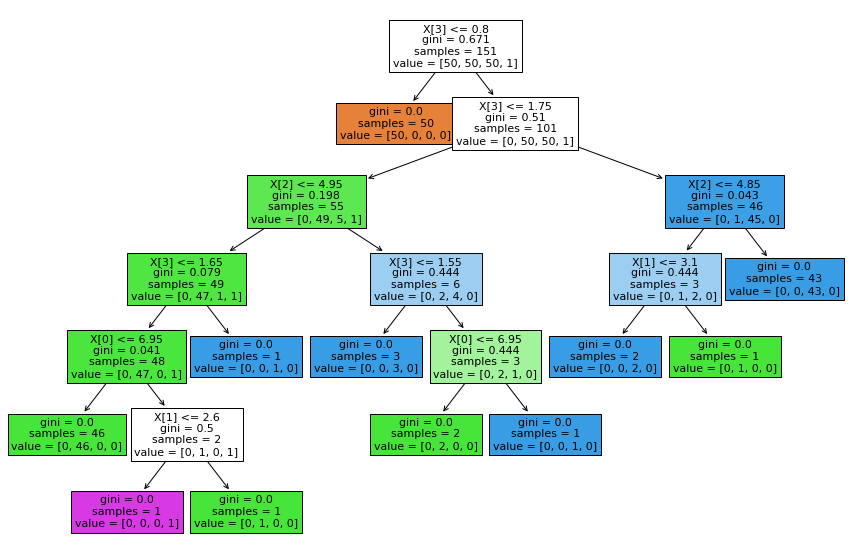

In [4]:
# example code with no safety

from sklearn.tree import DecisionTreeClassifier

rawDT = DecisionTreeClassifier(min_samples_leaf=1, criterion="gini", random_state=1)
rawDT.fit(X, y)

print(f"Training set accuracy in this naive case is {rawDT.score(X,y)}")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
output = plot_tree(rawDT, filled=True, ax=ax, fontsize=11)

### As we can see we have several disclosive nodes, one of which is our added point (in purple)
The exact values cannot be inferred but if we (reasonably) assume all features are non-negative we can get uper and lower bounds for the attribute values on that node:  
> (6.95,inf),  \[0,2.6\],  (0,4.95\],  (0.8, 1.65\]

so this is disclosive to a certain degree.

- In this case I spent 5 minutes manually tuning the values of the added point so that the tree included at least one decision node for each feature

- It would be fairly trivial to use something like a Genetic Algorithm to automatically tune the feature values of the added point minimising the difference between the upper and lower bounds for each feature.

- But that is not really the point of this exercise which was to show that allowing the user to set inappropriate values for a single parameter could produce a disclosive tree. 


### Diligent user realises problem, and changes their code to enforce at least n samples in each leaf
We'll use n=5 

Training set accuracy with threshold rule enforced is 0.9668874172185431


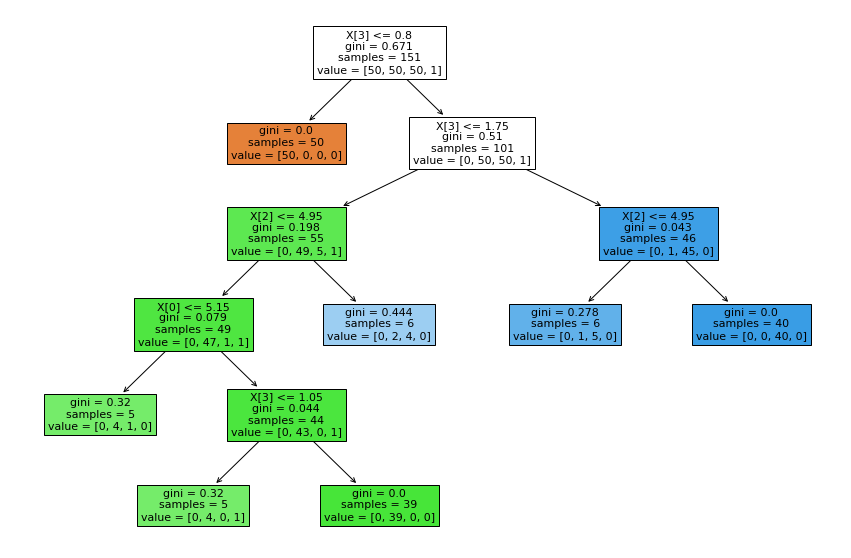

In [5]:
manualDT = DecisionTreeClassifier(min_samples_leaf=5, random_state=1)
manualDT.fit(X, y)

print(f"Training set accuracy with threshold rule enforced is {manualDT.score(X,y)}")

fig2, ax2 = plt.subplots(1, 1, figsize=(15, 10))
output = plot_tree(manualDT, filled=True, ax=ax2, fontsize=11)

### output is now non-disclosive (at least according to the threshold rule)
- You can easily see we don't get a node for the new class 3

## So lets define a new class SafeDecisionTreeClassifier 


In [6]:
from safemodel.safemodel import SafeModel
from safemodel.classifiers import SafeDecisionTreeClassifier

2022-08-26 07:58:44.511046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 07:58:44.511108: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


NameError: name 'key' is not defined

In [ ]:
noNameModel = SafeModel()

try:
    print(noNameModel.__str__())
except:
    print("super class has no attributes to print")

In [ ]:
safeDTModel = SafeDecisionTreeClassifier(min_samples_leaf=5)  # (criterion="entropy")
print(safeDTModel.__str__())

In [ ]:
msg, disclosive = safeDTModel.posthoc_check()
print(f"disclosive currently {disclosive}")
print("Because " + msg)

safeDTModel.fit(X, y)

print(f"Training set accuracy in this naive case is {safeDTModel.score(X,y)}")

In [ ]:
msg, disclosive = safeDTModel.posthoc_check()
print(f"disclosive currently {disclosive}")
if disclosive:
    print("Because " + msg)


safeDTModel.min_samples_leaf = 9
safeDTModel.min_samples_split = 1
msg, disclosive = safeDTModel.posthoc_check()
print(f"disclosive currently {disclosive}")
if disclosive:
    print("Because " + msg)


safeDTModel.min_samples_leaf = 5
safeDTModel.min_samples_split = 2
msg, disclosive = safeDTModel.posthoc_check()
print(f"disclosive currently {disclosive}")
if disclosive:
    print("Because " + msg)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# output = plot_tree(safeDTModel.model,filled=True, ax=ax,fontsize=11)

output = plot_tree(safeDTModel, filled=True, ax=ax, fontsize=11)

## Now demonstrate the save and reporting functionality

In [ ]:
safeDTModel.save(name="testSave.pkl")
safeDTModel.preliminary_check()
safeDTModel.request_release("testSave.pkl")

## Now lets try to attack this approach
### starting with listing the params then trying to set the params manually after init

In [ ]:
print(safeDTModel.__dict__)

In [ ]:
safeDTModel.min_samples_leaf = 1

safeDTModel.fit(X, y)

print(f"Training set accuracy in this naive case is {safeDTModel.score(X,y)}")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
output = plot_tree(safeDTModel, filled=True, ax=ax, fontsize=11)

## Example Implemenation runs
 

In [ ]:
# create and fit using recomended params
print("***researcher doesn't change recomended params")
safeDTModel2 = SafeDecisionTreeClassifier()
safeDTModel2.fit(X, y)
safeDTModel2.save(name="safe2.pkl")
safeDTModel2.preliminary_check()
safeDTModel2.posthoc_check()
safeDTModel2.request_release(filename="safe2.pkl")

In [ ]:
# change model params to recommended values
print("\n***researcher changes params safely")
safeDTModel3 = SafeDecisionTreeClassifier()
safeDTModel3.min_samples_leaf = 5
safeDTModel3.fit(X, y)
safeDTModel3.save(name="safe3.pkl")
safeDTModel3.preliminary_check()
safeDTModel3.posthoc_check()
safeDTModel3.request_release(filename="safe3.pkl")

In [ ]:
# change model params in a safe way
print("\n***researcher changes params safely")
safeDTModel4 = SafeDecisionTreeClassifier()
safeDTModel4.min_samples_leaf = 10
safeDTModel4.fit(X, y)
safeDTModel4.save(name="safe4.pkl")
safeDTModel4.preliminary_check()
safeDTModel4.posthoc_check()
safeDTModel4.request_release(filename="safe4.pkl")

In [ ]:
# change model params in an  unsafe way
print("\n***researcher changes params unsafely")
safeDTModel5 = SafeDecisionTreeClassifier()
safeDTModel5.min_samples_leaf = 1
safeDTModel5.save(name="unsafe.pkl")
safeDTModel5.preliminary_check()
safeDTModel5.posthoc_check()
safeDTModel5.request_release(filename="unsafe.pkl")

In [ ]:
# ask for a model with unsafe param values
print("\n***researcher asks for a safe_decision tree but supplies with unsafe params")
safeDTModel6 = SafeDecisionTreeClassifier(min_samples_leaf=1)
safeDTModel6.fit(X, y)
safeDTModel6.save(name="fixed-unsafe.pkl")
safeDTModel6.preliminary_check()
safeDTModel6.posthoc_check()
safeDTModel6.request_release(filename="fixed-unsafe.pkl")

In [ ]:
# trains a model with unsafe param values then  hacks values back to safe ones later
print(
    "\n***researcher asks for a safe_decision tree, changes values to unsafe before fit() then back afterwards"
)
safeDTModel7 = SafeDecisionTreeClassifier(min_samples_leaf=1)

safeDTModel7.min_samples_leaf = 1
safeDTModel7.fit(X, y)
print(f"safeDTmodel7.score on training set is {safeDTModel7.score(X,y)}")
print(f"fit called. with min_samples_leaf = {safeDTModel7.min_samples_leaf}")
safeDTModel7.min_samples_leaf = 5


safeDTModel7.save(name="hacked-unsafe.pkl")
msg, disclosive = safeDTModel7.preliminary_check()
print(f"preliminary message is:{msg}")
print(f"preliminary disclosive is:{disclosive}")
msg2, disclosive2 = safeDTModel7.posthoc_check()
print(f"posthoc message is:{msg2}")
print(f"posthoc disclosive is:{disclosive2}")
safeDTModel7.request_release(filename="hacked-unsafe.pkl")

In [ ]:
!echo "contents of checkfile are"; cat *_checkfile.json